In [1]:
!pip install tsai optuna  optuna-integration -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import notebookcfa27bdb31 as ArrayGenerator
from tsai.all import *
from fastai.callback.all import *
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import random

* To get consistent results

In [3]:
torch.manual_seed(37)  # tsai is built on it so this should work..... I think?
random.seed(37)
np.random.seed(37)

In [4]:
df = pd.read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)

In [5]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])

In [6]:
# changed split method to split by bearing
raw_X, raw_y = ArrayGenerator.generate_dataset_array(
    dataset_category=4, ts=X, labels=y, split_method="bearing"
)

{'Faults classified': 'LXC, XC, Looseness', 'Channels taken': 'All', 'Labels array': 'Binary'}


In [7]:
def ts_without_NaN(ts):
    new_ts = []
    for value in ts:
        if not np.isnan(value):
            new_ts.append(value)
    return new_ts

In [8]:
# Padding function
def pad(array_3d):
    max_length = max(len(sub_arr) for arr in array_3d for sub_arr in arr)
    padded_array_3d = [
        [
            np.pad(sub_arr, (0, max_length - len(sub_arr)), mode="constant")
            for sub_arr in arr
        ]
        for arr in array_3d
    ]
    return np.array(padded_array_3d)

In [9]:
# Purging NaN values from our data to get its FFT
x_nonan = []
for bearing in raw_X:
    x_nonan.append(bearing[:, ~np.any(np.isnan(bearing), axis=0)])

* for training on raw timeseries without windowing

In [10]:
x_nonan_padded = pad(x_nonan)

In [11]:
#  applying earlystopping to get the best results and to prevent overfitting
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
]

In [12]:
tfms = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]

In [13]:
report_splits = get_splits(raw_y, valid_size=0.2, shuffle=True, show_plot=False)
X_train1, y_train1 = raw_X[report_splits[0]], raw_y[report_splits[0]]
X_test1, y_test1 = raw_X[report_splits[1]], raw_y[report_splits[1]]

In [14]:
def objective(trial):
    bs = trial.suggest_int("bs", 16, 128)  # suggest batch size
    apply_sliding_window = trial.suggest_categorical(
        "apply_sliding_window", [0, 1]
    )  # suggest whether to apply sliding window or not
    no_of_layers = trial.suggest_int("no_of_layers", 1, 2)  # suggest number of layers
    layers = []
    dropouts = []
    for i in range(no_of_layers):  # loop over every layer
        layers.append(
            trial.suggest_int("no_of_neurons_l{}".format(i), 8, 64)
        )  # suggest each layer size
        dropouts.append(
            trial.suggest_float("dropout_l{}".format(i), 0.0, 0.6)
        )  # suggest dropout rate

    lr = trial.suggest_float("lr", 1e-5, 1e-1)  # suggest learning rate

    if apply_sliding_window:
        overlap_pct = trial.suggest_float(
            "overlap_pct", 0.0, 1.0
        )  # suggest overlap pct
        with_fft = trial.suggest_categorical(
            "with_fft", [0, 1]
        )  # suggest whether to apply FFT or not

        if overlap_pct > 0.5:  # to avoid an error in ArrayGenerator

            window_size1 = trial.suggest_categorical(
                "window_size1", [2048, 4096]
            )  # suggest window size # to avoid CategoricalDistribution does not support dynamic value space error
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size1,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size1,
                with_fft=with_fft,
                overlap_pct=0,
            )

        elif overlap_pct > 0.25:
            window_size2 = trial.suggest_categorical(
                "window_size2", [2048, 4096, 8192]
            )  # suggest window size
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size2,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size2,
                with_fft=with_fft,
                overlap_pct=0,
            )
        else:
            window_size3 = trial.suggest_categorical(
                "window_size3", [2048, 4096, 8192, 16384]
            )  # suggest window size
            X_train, y_train = ArrayGenerator.apply_sliding_window(
                X_train1,
                y_train1,
                window_size=window_size3,
                with_fft=with_fft,
                overlap_pct=overlap_pct,
            )
            X_test, y_test = ArrayGenerator.apply_sliding_window(
                X_test1,
                y_test1,
                window_size=window_size3,
                with_fft=with_fft,
                overlap_pct=0,
            )
        train_balance_splits = get_splits(
            y_train,
            valid_size=0,
            balance=True,
            strategy="oversample",
            shuffle=True,
            show_plot=False,
        )
        X_train, y_train = (
            X_train[train_balance_splits[0]],
            y_train[train_balance_splits[0]],
        )
        X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
        dls = get_ts_dls(
            X,
            y,
            splits=splits,
            tfms=tfms,
            shuffle_train=True,
            batch_tfms=batch_tfms,
            bs=[bs, 256],
        )
        seq_len = X_train.shape[-1]
    else:
        dls = get_ts_dls(
            x_nonan_padded,
            raw_y,
            splits=report_splits,
            tfms=tfms,
            shuffle_train=True,
            batch_tfms=batch_tfms,
            bs=[bs, 256],
        )
        seq_len = 16384
    model = MLP(
        dls.vars, dls.c, seq_len=seq_len, layers=layers, ps=dropouts, use_bn=True
    )
    learn = Learner(
        dls,
        model,
        lr=lr,
        metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
    )

    with learn.no_logging(), learn.no_bar():
        learn.fit_one_cycle(15, cbs=callbacks)

    return learn.validate()[-2]  # return F1 score

# optimizing (full optuna output is at the end)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=2400)

# Results

In [16]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

optuna.importance.get_param_importances(study)

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.819571865443425
  Params: 
    bs: 105
    apply_sliding_window: 1
    no_of_layers: 1
    no_of_neurons_l0: 10
    dropout_l0: 0.540552475105706
    lr: 0.006338275154888864
    overlap_pct: 0.5176895746636483
    with_fft: 1
    window_size1: 4096


{'lr': 0.5449955042921544,
 'bs': 0.20768141701968565,
 'no_of_neurons_l0': 0.0904460636722904,
 'dropout_l0': 0.08286233999228156,
 'apply_sliding_window': 0.05571496068052522,
 'no_of_layers': 0.018299714343062847}

In [17]:
plotly_config = {"staticPlot": True}
fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [18]:
fig = plot_param_importances(study)
fig.show(config=plotly_config)

* getting the variables ready to train on them 

In [19]:
layers = []
dropouts = []
if trial.params["no_of_layers"] == 1:
    layers = trial.params["no_of_neurons_l0"]
    dropouts = trial.params["dropout_l0"]
else:
    layers.append(trial.params["no_of_neurons_l0"])
    layers.append(trial.params["no_of_neurons_l1"])
    dropouts.append(trial.params["dropout_l0"])
    dropouts.append(trial.params["dropout_l1"])

# Training with the best found hyperparamters

In [20]:
if apply_sliding_window:
    if trial.params["overlap_pct"] > 0.5:  # to avoid an error in ArrayGenerator
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size1"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size1"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )

    elif trial.params["overlap_pct"] > 0.25:
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size2"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size2"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )
    else:
        X_train, y_train = ArrayGenerator.apply_sliding_window(
            X_train1,
            y_train1,
            window_size=trial.params["window_size3"],
            with_fft=trial.params["with_fft"],
            overlap_pct=trial.params["overlap_pct"],
        )
        X_test, y_test = ArrayGenerator.apply_sliding_window(
            X_test1,
            y_test1,
            window_size=trial.params["window_size3"],
            with_fft=trial.params["with_fft"],
            overlap_pct=0,
        )
    train_balance_splits = get_splits(
        y_train,
        valid_size=0,
        balance=True,
        strategy="oversample",
        shuffle=True,
        show_plot=False,
    )
    X_train, y_train = (
        X_train[train_balance_splits[0]],
        y_train[train_balance_splits[0]],
    )
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    dls = get_ts_dls(
        X,
        y,
        splits=splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[trial.params["bs"], 256],
    )
    seq_len = X_train.shape[-1]
else:
    dls = get_ts_dls(
        x_nonan_padded,
        raw_y,
        splits=report_splits,
        tfms=tfms,
        shuffle_train=True,
        batch_tfms=batch_tfms,
        bs=[trial.params["bs"], 256],
    )
    seq_len = 16384
model = MLP(dls.vars, dls.c, seq_len=seq_len, layers=layers, ps=dropouts, use_bn=True)
learn = Learner(
    dls,
    model,
    lr=trial.params["lr"],
    metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
)

learn.fit_one_cycle(15, cbs=callbacks);

valid == train


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.561188,0.494855,0.761792,0.702703,0.738636,0.720222,0.758431,00:00
1,0.436204,0.426398,0.846698,0.836364,0.784091,0.809384,0.837610,00:00
2,0.347013,0.452005,0.820755,0.787356,0.778409,0.782857,0.814608,00:00
3,0.294291,0.476842,0.813679,0.765027,0.795455,0.779944,0.811034,00:00
4,0.254716,0.544179,0.839623,0.864865,0.727273,0.790123,0.823314,00:00


No improvement since epoch 1: early stopping


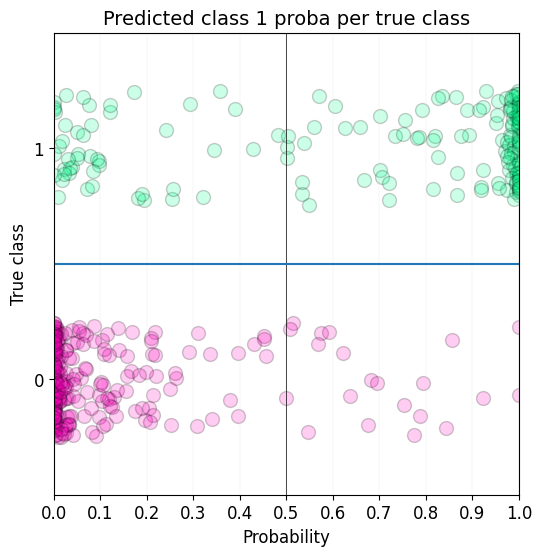

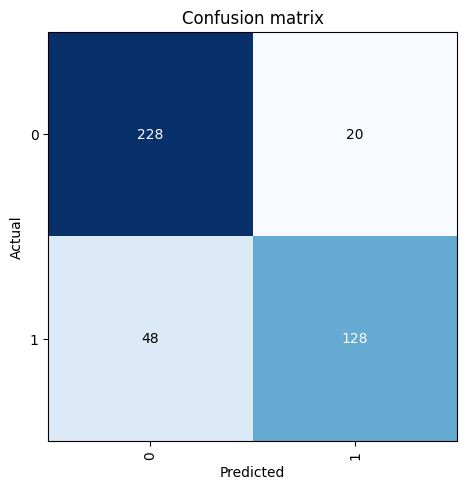

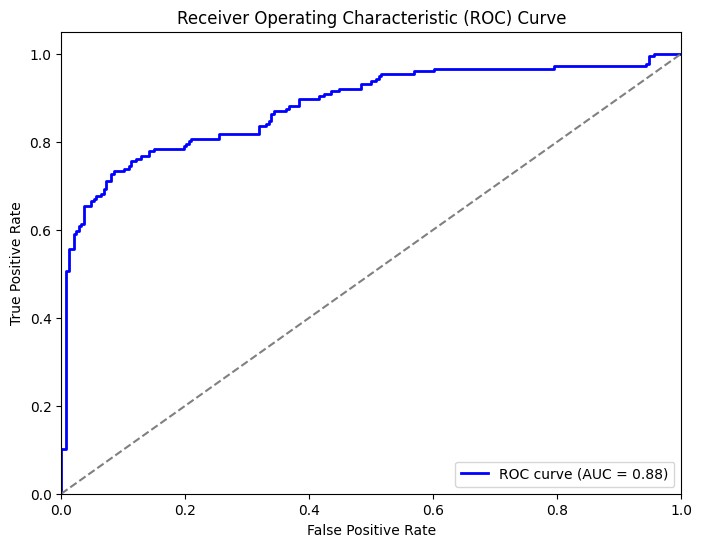

In [21]:
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

[I 2024-04-18 03:57:24,202] A new study created in memory with name: no-name-e6278a96-163d-43c6-9235-b09018b0ce49


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
3,0.294291,0.476842,0.813679,0.765027,0.795455,0.779944,0.811034


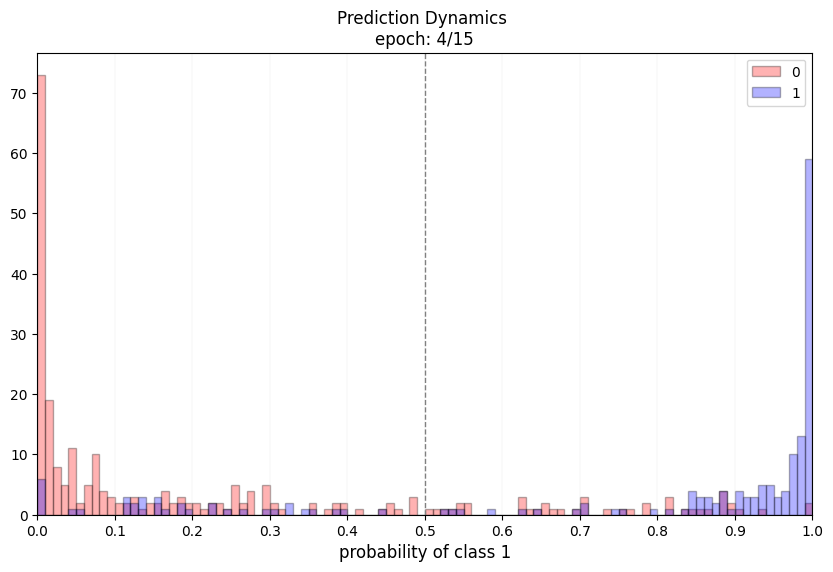

No improvement since epoch 3: early stopping


[I 2024-04-18 03:57:30,550] Trial 0 finished with value: 0.21052631578947367 and parameters: {'bs': 104, 'apply_sliding_window': 0, 'no_of_layers': 2, 'no_of_neurons_l0': 50, 'dropout_l0': 0.44477958887064123, 'no_of_neurons_l1': 10, 'dropout_l1': 0.5015160155594669, 'lr': 0.09601224674460528}. Best is trial 0 with value: 0.21052631578947367.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 03:57:45,154] Trial 1 finished with value: 0.02247191011235955 and parameters: {'bs': 21, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 63, 'dropout_l0': 0.40749515078709525, 'no_of_neurons_l1': 26, 'dropout_l1': 0.4276495882266193, 'lr': 0.08075693040621576, 'overlap_pct': 0.574161472589343, 'with_fft': 0, 'window_size1': 4096}. Best is trial 0 with value: 0.21052631578947367.


No improvement since epoch 1: early stopping


[I 2024-04-18 03:57:49,470] Trial 2 finished with value: 0.17204301075268816 and parameters: {'bs': 93, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 52, 'dropout_l0': 0.5162455347399549, 'lr': 0.07782995887033901}. Best is trial 0 with value: 0.21052631578947367.


No improvement since epoch 2: early stopping


[I 2024-04-18 03:57:54,463] Trial 3 finished with value: 0.4347826086956521 and parameters: {'bs': 71, 'apply_sliding_window': 0, 'no_of_layers': 2, 'no_of_neurons_l0': 18, 'dropout_l0': 0.08458443471362499, 'no_of_neurons_l1': 53, 'dropout_l1': 0.510721164387019, 'lr': 0.08943963489472193}. Best is trial 3 with value: 0.4347826086956521.


No improvement since epoch 3: early stopping


[I 2024-04-18 03:58:00,450] Trial 4 finished with value: 0.0 and parameters: {'bs': 48, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 27, 'dropout_l0': 0.3066781168221892, 'lr': 0.06405413904694347}. Best is trial 3 with value: 0.4347826086956521.


No improvement since epoch 2: early stopping


[I 2024-04-18 03:58:05,508] Trial 5 finished with value: 0.1758241758241758 and parameters: {'bs': 106, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 36, 'dropout_l0': 0.33777460049991265, 'lr': 0.03510291745629374}. Best is trial 3 with value: 0.4347826086956521.


No improvement since epoch 6: early stopping


[I 2024-04-18 03:58:13,834] Trial 6 finished with value: 0.553191489361702 and parameters: {'bs': 124, 'apply_sliding_window': 0, 'no_of_layers': 2, 'no_of_neurons_l0': 28, 'dropout_l0': 0.14929585499803255, 'no_of_neurons_l1': 23, 'dropout_l1': 0.3211878703919743, 'lr': 0.032497256864603155}. Best is trial 6 with value: 0.553191489361702.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 03:58:25,890] Trial 7 finished with value: 0.1979695431472081 and parameters: {'bs': 49, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.02269928917641617, 'lr': 0.0477624296199894, 'overlap_pct': 0.5564502549550803, 'with_fft': 1, 'window_size1': 2048}. Best is trial 6 with value: 0.553191489361702.


No improvement since epoch 1: early stopping


[I 2024-04-18 03:58:30,428] Trial 8 finished with value: 0.45762711864406774 and parameters: {'bs': 37, 'apply_sliding_window': 0, 'no_of_layers': 2, 'no_of_neurons_l0': 27, 'dropout_l0': 0.09392089786530049, 'no_of_neurons_l1': 62, 'dropout_l1': 0.2804622841356505, 'lr': 0.0694535755252977}. Best is trial 6 with value: 0.553191489361702.


No improvement since epoch 4: early stopping


[I 2024-04-18 03:58:37,521] Trial 9 finished with value: 0.18556701030927833 and parameters: {'bs': 30, 'apply_sliding_window': 0, 'no_of_layers': 2, 'no_of_neurons_l0': 27, 'dropout_l0': 0.38299690182964324, 'no_of_neurons_l1': 31, 'dropout_l1': 0.44924906160715217, 'lr': 0.05784123653614942}. Best is trial 6 with value: 0.553191489361702.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 03:58:50,464] Trial 10 finished with value: 0.6352583586626139 and parameters: {'bs': 127, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 44, 'dropout_l0': 0.19361592152961998, 'no_of_neurons_l1': 9, 'dropout_l1': 0.03890247030862404, 'lr': 0.008794606772081378, 'overlap_pct': 0.01515135927054334, 'with_fft': 0, 'window_size3': 2048}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 03:58:57,424] Trial 11 finished with value: 0.5813953488372093 and parameters: {'bs': 127, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 42, 'dropout_l0': 0.20194957565230426, 'no_of_neurons_l1': 8, 'dropout_l1': 0.00787058043915314, 'lr': 0.002455993546314073, 'overlap_pct': 0.016631491487745675, 'with_fft': 0, 'window_size3': 2048}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 10: early stopping


[I 2024-04-18 03:59:12,787] Trial 12 finished with value: 0.620583717357911 and parameters: {'bs': 125, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 46, 'dropout_l0': 0.20206013059842837, 'no_of_neurons_l1': 11, 'dropout_l1': 0.012066864177177356, 'lr': 0.0025684782245170177, 'overlap_pct': 0.024141905567065237, 'with_fft': 0, 'window_size3': 2048}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 03:59:20,276] Trial 13 finished with value: 0.5366726296958855 and parameters: {'bs': 81, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 46, 'dropout_l0': 0.19360465821315437, 'no_of_neurons_l1': 16, 'dropout_l1': 0.01634501658145142, 'lr': 0.006083764996768808, 'overlap_pct': 0.0014265828733465748, 'with_fft': 0, 'window_size3': 2048}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 4: early stopping


[I 2024-04-18 03:59:31,523] Trial 14 finished with value: 0.5955414012738853 and parameters: {'bs': 115, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 57, 'dropout_l0': 0.23540342313533585, 'no_of_neurons_l1': 41, 'dropout_l1': 0.12923122132509554, 'lr': 0.017568110521983107, 'overlap_pct': 0.2707308312104203, 'with_fft': 0, 'window_size2': 2048}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:00:03,339] Trial 15 finished with value: 0.6107382550335572 and parameters: {'bs': 87, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 37, 'dropout_l0': 0.2661553001983084, 'no_of_neurons_l1': 18, 'dropout_l1': 0.13604977122755887, 'lr': 0.02166820863683092, 'overlap_pct': 0.9418728300346285, 'with_fft': 0, 'window_size1': 4096}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:00:08,360] Trial 16 finished with value: 0.0 and parameters: {'bs': 109, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 39, 'dropout_l0': 0.597950051873658, 'no_of_neurons_l1': 41, 'dropout_l1': 0.1365625140230008, 'lr': 0.01652326895247592, 'overlap_pct': 0.2402898023963484, 'with_fft': 1, 'window_size3': 16384}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 5: early stopping


[I 2024-04-18 04:00:17,937] Trial 17 finished with value: 0.5784615384615385 and parameters: {'bs': 65, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 58, 'dropout_l0': 0.13299769244143259, 'lr': 0.00183472324921731, 'overlap_pct': 0.2508940855609732, 'with_fft': 0, 'window_size2': 4096}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:00:26,859] Trial 18 finished with value: 0.5764499121265377 and parameters: {'bs': 127, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 46, 'dropout_l0': 0.013624770785672896, 'no_of_neurons_l1': 16, 'dropout_l1': 0.07355837450109558, 'lr': 0.035811059821199816, 'overlap_pct': 0.1364936575062912, 'with_fft': 0, 'window_size3': 2048}. Best is trial 10 with value: 0.6352583586626139.


valid == train
No improvement since epoch 6: early stopping


[I 2024-04-18 04:00:36,780] Trial 19 finished with value: 0.7425742574257426 and parameters: {'bs': 95, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 35, 'dropout_l0': 0.2799970671076208, 'no_of_neurons_l1': 34, 'dropout_l1': 0.2211457514966363, 'lr': 0.011270555670526046, 'overlap_pct': 0.4328520133558773, 'with_fft': 1, 'window_size2': 8192}. Best is trial 19 with value: 0.7425742574257426.


valid == train
No improvement since epoch 5: early stopping


[I 2024-04-18 04:01:01,099] Trial 20 finished with value: 0.783625730994152 and parameters: {'bs': 95, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 20, 'dropout_l0': 0.31646042248200257, 'lr': 0.025890099558631512, 'overlap_pct': 0.7558820919399113, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:01:19,699] Trial 21 finished with value: 0.7024390243902439 and parameters: {'bs': 95, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 17, 'dropout_l0': 0.3333985580555354, 'lr': 0.026655999275981675, 'overlap_pct': 0.788242490041233, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:01:37,434] Trial 22 finished with value: 0.7180156657963447 and parameters: {'bs': 95, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 15, 'dropout_l0': 0.3393895666820494, 'lr': 0.0260348663659479, 'overlap_pct': 0.7763754591948272, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:01:56,649] Trial 23 finished with value: 0.6583850931677018 and parameters: {'bs': 78, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 9, 'dropout_l0': 0.27466205127463483, 'lr': 0.04176813211643857, 'overlap_pct': 0.7677708654623526, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 4: early stopping


[I 2024-04-18 04:02:04,692] Trial 24 finished with value: 0.6666666666666666 and parameters: {'bs': 98, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 18, 'dropout_l0': 0.46671753259654025, 'lr': 0.02662776586238807, 'overlap_pct': 0.42746931692080026, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:02:20,310] Trial 25 finished with value: 0.7514285714285713 and parameters: {'bs': 85, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 32, 'dropout_l0': 0.3501754432913955, 'lr': 0.012750921839321095, 'overlap_pct': 0.6648474410844909, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:02:27,105] Trial 26 finished with value: 0.7655502392344496 and parameters: {'bs': 62, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 33, 'dropout_l0': 0.377052649095908, 'lr': 0.015709739771304146, 'overlap_pct': 0.44514723856420957, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:02:42,514] Trial 27 finished with value: 0.7275449101796406 and parameters: {'bs': 62, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 31, 'dropout_l0': 0.3787508905054127, 'lr': 0.014669365821394317, 'overlap_pct': 0.6569852805691759, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:03:45,931] Trial 28 finished with value: 0.2081218274111675 and parameters: {'bs': 57, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 22, 'dropout_l0': 0.447303787337953, 'lr': 0.04453963620563483, 'overlap_pct': 0.9402977036686346, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:04:01,628] Trial 29 finished with value: 0.1276595744680851 and parameters: {'bs': 75, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 23, 'dropout_l0': 0.49641574030723434, 'lr': 0.05373948513961886, 'overlap_pct': 0.6816098499859103, 'with_fft': 1, 'window_size1': 2048}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:04:08,193] Trial 30 finished with value: 0.7155963302752293 and parameters: {'bs': 84, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 31, 'dropout_l0': 0.523242804542786, 'lr': 0.02331654247005086, 'overlap_pct': 0.44324333493931856, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:04:14,587] Trial 31 finished with value: 0.7630057803468209 and parameters: {'bs': 90, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 35, 'dropout_l0': 0.29344071325674814, 'lr': 0.010759062793454028, 'overlap_pct': 0.37873425236135283, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:04:21,703] Trial 32 finished with value: 0.7741935483870968 and parameters: {'bs': 87, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 33, 'dropout_l0': 0.41328246386026934, 'lr': 0.010051875796147936, 'overlap_pct': 0.3303611379894132, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:04:26,497] Trial 33 finished with value: 0.7011494252873564 and parameters: {'bs': 69, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 23, 'dropout_l0': 0.40299531430258195, 'lr': 0.020178589782521798, 'overlap_pct': 0.3416490726149314, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:04:33,543] Trial 34 finished with value: 0.7526881720430106 and parameters: {'bs': 101, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 40, 'dropout_l0': 0.4244289155881414, 'lr': 0.008548200548438516, 'overlap_pct': 0.3354553232015293, 'with_fft': 1, 'window_size2': 8192}. Best is trial 20 with value: 0.783625730994152.


valid == train
No improvement since epoch 6: early stopping


[I 2024-04-18 04:04:46,360] Trial 35 finished with value: 0.7967032967032968 and parameters: {'bs': 90, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 51, 'dropout_l0': 0.3059156655734455, 'lr': 0.028401270067748317, 'overlap_pct': 0.5076991004723859, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:04:53,134] Trial 36 finished with value: 0.7478753541076488 and parameters: {'bs': 112, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 53, 'dropout_l0': 0.375629096088348, 'lr': 0.031518013868995734, 'overlap_pct': 0.5225717735365648, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


No improvement since epoch 1: early stopping


[I 2024-04-18 04:04:57,626] Trial 37 finished with value: 0.1956521739130435 and parameters: {'bs': 55, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 64, 'dropout_l0': 0.3182810429751533, 'lr': 0.03724574051983796}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:05:12,328] Trial 38 finished with value: 0.7272727272727273 and parameters: {'bs': 69, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 50, 'dropout_l0': 0.24143159485931454, 'lr': 0.029236629932848028, 'overlap_pct': 0.8544878925606083, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


No improvement since epoch 0: early stopping


[I 2024-04-18 04:05:15,931] Trial 39 finished with value: 0.4666666666666667 and parameters: {'bs': 104, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 21, 'dropout_l0': 0.4246545938744957, 'lr': 0.04128981664894102}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:05:23,788] Trial 40 finished with value: 0.6105263157894737 and parameters: {'bs': 118, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 14, 'dropout_l0': 0.47877805935382345, 'lr': 0.08663960193202871, 'overlap_pct': 0.623513513619282, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:05:29,609] Trial 41 finished with value: 0.735632183908046 and parameters: {'bs': 90, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 32, 'dropout_l0': 0.3056378740539288, 'lr': 0.01826171248203684, 'overlap_pct': 0.3650667243775941, 'with_fft': 1, 'window_size2': 8192}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:05:34,224] Trial 42 finished with value: 0.7192982456140351 and parameters: {'bs': 79, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 36, 'dropout_l0': 0.3581952089947229, 'lr': 0.01325713837384972, 'overlap_pct': 0.49919942226144265, 'with_fft': 1, 'window_size2': 8192}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 04:05:48,532] Trial 43 finished with value: 0.7663043478260869 and parameters: {'bs': 89, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 28, 'dropout_l0': 0.2975327728035642, 'lr': 0.008156186881379616, 'overlap_pct': 0.5654615640006175, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


No improvement since epoch 1: early stopping


[I 2024-04-18 04:05:52,917] Trial 44 finished with value: 0.5828571428571429 and parameters: {'bs': 73, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 26, 'dropout_l0': 0.23516910822406295, 'lr': 0.005831558225599167}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:06:02,297] Trial 45 finished with value: 0.0 and parameters: {'bs': 43, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 29, 'dropout_l0': 0.4077434765699246, 'lr': 0.07166150480419478, 'overlap_pct': 0.5819436387684391, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:06:18,842] Trial 46 finished with value: 0.5428571428571429 and parameters: {'bs': 16, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 26, 'dropout_l0': 0.3188583343181274, 'lr': 0.02103882421233336, 'overlap_pct': 0.4756976480224134, 'with_fft': 1, 'window_size2': 2048}. Best is trial 35 with value: 0.7967032967032968.


No improvement since epoch 0: early stopping


[I 2024-04-18 04:06:21,877] Trial 47 finished with value: 0.5483870967741936 and parameters: {'bs': 101, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 12, 'dropout_l0': 0.25441979891607513, 'lr': 0.006201397056917593}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:06:29,162] Trial 48 finished with value: 0.7804878048780488 and parameters: {'bs': 89, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 20, 'dropout_l0': 0.3800491303149379, 'lr': 0.015982584397127107, 'overlap_pct': 0.5743537764707385, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:06:36,308] Trial 49 finished with value: 0.5866666666666668 and parameters: {'bs': 88, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 21, 'dropout_l0': 0.5389423612970504, 'lr': 0.0979298662154878, 'overlap_pct': 0.5668107150912747, 'with_fft': 1, 'window_size1': 4096}. Best is trial 35 with value: 0.7967032967032968.


valid == train
No improvement since epoch 5: early stopping


[I 2024-04-18 04:06:50,265] Trial 50 finished with value: 0.8108108108108109 and parameters: {'bs': 106, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 19, 'dropout_l0': 0.4451442261936684, 'lr': 0.0013943887939616177, 'overlap_pct': 0.7148417090583321, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 8: early stopping


[I 2024-04-18 04:07:07,257] Trial 51 finished with value: 0.7715133531157269 and parameters: {'bs': 109, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 19, 'dropout_l0': 0.4335572589976606, 'lr': 0.007013884502056603, 'overlap_pct': 0.7208176011478913, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train


[I 2024-04-18 04:07:27,577] Trial 52 finished with value: 0.7740112994350281 and parameters: {'bs': 120, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 15, 'dropout_l0': 0.45068930006835023, 'lr': 7.251836744494138e-05, 'overlap_pct': 0.7236280265642101, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:07:45,076] Trial 53 finished with value: 0.7715133531157269 and parameters: {'bs': 121, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 12, 'dropout_l0': 0.45830245150728455, 'lr': 0.0010338819306530856, 'overlap_pct': 0.8732429030134383, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 4: early stopping


[I 2024-04-18 04:07:58,111] Trial 54 finished with value: 0.788235294117647 and parameters: {'bs': 108, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 16, 'dropout_l0': 0.5556224635170575, 'lr': 0.0014100185380731337, 'overlap_pct': 0.7202103289157942, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:08:11,408] Trial 55 finished with value: 0.7714285714285715 and parameters: {'bs': 107, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 61, 'dropout_l0': 0.5704752200905426, 'lr': 0.023038791902633835, 'overlap_pct': 0.8470680475754586, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 10: early stopping


[I 2024-04-18 04:08:27,670] Trial 56 finished with value: 0.5819397993311036 and parameters: {'bs': 100, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 25, 'dropout_l0': 0.48829358498203196, 'lr': 0.004651822948261932, 'overlap_pct': 0.6180023647866503, 'with_fft': 0, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 8: early stopping


[I 2024-04-18 04:08:39,365] Trial 57 finished with value: 0.7650273224043714 and parameters: {'bs': 83, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 19, 'dropout_l0': 0.5606890831011021, 'lr': 0.009828504980329078, 'overlap_pct': 0.14111821487324186, 'with_fft': 1, 'window_size3': 8192}. Best is trial 50 with value: 0.8108108108108109.


No improvement since epoch 2: early stopping


[I 2024-04-18 04:08:44,524] Trial 58 finished with value: 0.4999999999999999 and parameters: {'bs': 113, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 11, 'dropout_l0': 0.40261460755990364, 'lr': 0.01670604815304433}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 5: early stopping


[I 2024-04-18 04:08:57,406] Trial 59 finished with value: 0.6092307692307692 and parameters: {'bs': 93, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 15, 'dropout_l0': 0.3577495073921021, 'lr': 0.0039894290783919276, 'overlap_pct': 0.7146070852956103, 'with_fft': 0, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:09:09,306] Trial 60 finished with value: 0.6826666666666668 and parameters: {'bs': 97, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 55, 'dropout_l0': 0.5125776784980884, 'lr': 0.03293518483982462, 'overlap_pct': 0.8183137808742245, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:09:21,296] Trial 61 finished with value: 0.7951807228915662 and parameters: {'bs': 105, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 14, 'dropout_l0': 0.45543856399247046, 'lr': 0.00105309298844796, 'overlap_pct': 0.7376177883851865, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:09:32,466] Trial 62 finished with value: 0.7470588235294118 and parameters: {'bs': 106, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 17, 'dropout_l0': 0.4039438399634456, 'lr': 0.011720654946716489, 'overlap_pct': 0.7496815357760316, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:09:42,133] Trial 63 finished with value: 0.7925696594427246 and parameters: {'bs': 104, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 9, 'dropout_l0': 0.5806175821081648, 'lr': 0.0024381679227410066, 'overlap_pct': 0.6065487276910466, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 4: early stopping


[I 2024-04-18 04:09:53,413] Trial 64 finished with value: 0.788235294117647 and parameters: {'bs': 103, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.5995343795716461, 'lr': 0.0032335025061297935, 'overlap_pct': 0.6159723018765716, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 10: early stopping


[I 2024-04-18 04:10:11,050] Trial 65 finished with value: 0.7941176470588234 and parameters: {'bs': 111, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.5895282061212497, 'lr': 0.00016938680255170662, 'overlap_pct': 0.6287888702975917, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 9: early stopping


[I 2024-04-18 04:10:26,110] Trial 66 finished with value: 0.5396825396825398 and parameters: {'bs': 115, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 9, 'dropout_l0': 0.59921529491714, 'lr': 0.0007515724973643121, 'overlap_pct': 0.6377210053155821, 'with_fft': 0, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 11: early stopping


[I 2024-04-18 04:10:45,898] Trial 67 finished with value: 0.8058823529411765 and parameters: {'bs': 109, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.5727847033628617, 'lr': 0.00407839428418405, 'overlap_pct': 0.6870246291269441, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train


[I 2024-04-18 04:11:05,702] Trial 68 finished with value: 0.7399463806970509 and parameters: {'bs': 111, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.5607683190276753, 'lr': 6.469726695359127e-05, 'overlap_pct': 0.6759225945153283, 'with_fft': 1, 'window_size1': 4096}. Best is trial 50 with value: 0.8108108108108109.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 04:11:19,144] Trial 69 finished with value: 0.8192771084337349 and parameters: {'bs': 124, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 13, 'dropout_l0': 0.5766174913434439, 'lr': 0.004441243565435096, 'overlap_pct': 0.5357592297569512, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 4: early stopping


[I 2024-04-18 04:11:29,763] Trial 70 finished with value: 0.7876923076923077 and parameters: {'bs': 122, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 13, 'dropout_l0': 0.5762168008520901, 'lr': 0.004589138737777654, 'overlap_pct': 0.530244131248432, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 04:11:44,691] Trial 71 finished with value: 0.7917888563049853 and parameters: {'bs': 117, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.5444946578098315, 'lr': 0.0034050969016230243, 'overlap_pct': 0.6973838653095065, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 10: early stopping


[I 2024-04-18 04:12:02,745] Trial 72 finished with value: 0.802469135802469 and parameters: {'bs': 116, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.5367360386751452, 'lr': 0.00785142534671976, 'overlap_pct': 0.682397075713911, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 4: early stopping


[I 2024-04-18 04:12:18,604] Trial 73 finished with value: 0.764872521246459 and parameters: {'bs': 128, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.579637088820083, 'lr': 0.007682766672268698, 'overlap_pct': 0.8019436051007991, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:12:26,520] Trial 74 finished with value: 0.6203208556149732 and parameters: {'bs': 124, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 12, 'dropout_l0': 0.5290931605299325, 'lr': 0.060388866809596126, 'overlap_pct': 0.5989479372023443, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:12:34,739] Trial 75 finished with value: 0.7331670822942643 and parameters: {'bs': 115, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.5075335517783099, 'lr': 0.01330183827483915, 'overlap_pct': 0.6511350615998691, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 5: early stopping


[I 2024-04-18 04:12:49,796] Trial 76 finished with value: 0.7823834196891192 and parameters: {'bs': 111, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 13, 'dropout_l0': 0.5798038225345234, 'lr': 0.010103083210279473, 'overlap_pct': 0.7551466606936388, 'with_fft': 1, 'window_size1': 4096}. Best is trial 69 with value: 0.8192771084337349.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 04:13:03,463] Trial 77 finished with value: 0.819571865443425 and parameters: {'bs': 105, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.540552475105706, 'lr': 0.006338275154888864, 'overlap_pct': 0.5176895746636483, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


No improvement since epoch 6: early stopping


[I 2024-04-18 04:13:11,194] Trial 78 finished with value: 0.611764705882353 and parameters: {'bs': 118, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 13, 'dropout_l0': 0.5415895192221692, 'lr': 0.006297728058840922}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:13:19,311] Trial 79 finished with value: 0.46280991735537186 and parameters: {'bs': 124, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 11, 'dropout_l0': 0.5047375932846991, 'lr': 0.018456176964486273, 'overlap_pct': 0.5164177823443726, 'with_fft': 0, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:13:28,300] Trial 80 finished with value: 0.7602339181286549 and parameters: {'bs': 99, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 17, 'dropout_l0': 0.0976447568141672, 'lr': 0.011777887789010375, 'overlap_pct': 0.48481092054627195, 'with_fft': 1, 'window_size2': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 04:13:41,873] Trial 81 finished with value: 0.7906976744186046 and parameters: {'bs': 103, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.5883166043069563, 'lr': 0.00293176287668475, 'overlap_pct': 0.5369639961994094, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 11: early stopping


[I 2024-04-18 04:13:59,970] Trial 82 finished with value: 0.7794561933534743 and parameters: {'bs': 106, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 14, 'dropout_l0': 0.47499399674690557, 'lr': 0.007791266937066418, 'overlap_pct': 0.6548508607928185, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:14:09,385] Trial 83 finished with value: 0.6837881219903691 and parameters: {'bs': 113, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 9, 'dropout_l0': 0.5317968499132774, 'lr': 0.051735742335738584, 'overlap_pct': 0.4565600745090142, 'with_fft': 1, 'window_size2': 2048}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:14:16,305] Trial 84 finished with value: 0.778115501519757 and parameters: {'bs': 109, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 11, 'dropout_l0': 0.5501740025835679, 'lr': 0.004692953261849993, 'overlap_pct': 0.4147384396419198, 'with_fft': 1, 'window_size2': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 6: early stopping


[I 2024-04-18 04:14:29,011] Trial 85 finished with value: 0.7345679012345679 and parameters: {'bs': 104, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 48, 'dropout_l0': 0.5659539436143394, 'lr': 0.009396165445716548, 'overlap_pct': 0.5952595300136174, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:14:38,616] Trial 86 finished with value: 0.7934782608695653 and parameters: {'bs': 118, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.17197415969703908, 'lr': 0.013201063425321558, 'overlap_pct': 0.682034779443246, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:14:48,688] Trial 87 finished with value: 0.7868852459016393 and parameters: {'bs': 116, 'apply_sliding_window': 1, 'no_of_layers': 2, 'no_of_neurons_l0': 14, 'dropout_l0': 0.0555145476288509, 'no_of_neurons_l1': 53, 'dropout_l1': 0.5722300901206665, 'lr': 0.0061090029237990725, 'overlap_pct': 0.6890448061926783, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:14:58,542] Trial 88 finished with value: 0.7625000000000001 and parameters: {'bs': 119, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 42, 'dropout_l0': 0.1695242581223114, 'lr': 0.014960269334251803, 'overlap_pct': 0.7506448390713625, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 1: early stopping


[I 2024-04-18 04:15:09,992] Trial 89 finished with value: 0.7550077041602465 and parameters: {'bs': 125, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 16, 'dropout_l0': 0.21956896105291135, 'lr': 0.01339403869250693, 'overlap_pct': 0.5488600841936226, 'with_fft': 1, 'window_size1': 2048}. Best is trial 77 with value: 0.819571865443425.


No improvement since epoch 0: early stopping


[I 2024-04-18 04:15:13,516] Trial 90 finished with value: 0.2912621359223301 and parameters: {'bs': 122, 'apply_sliding_window': 0, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.5193029726747009, 'lr': 0.018981588150311722}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:15:24,153] Trial 91 finished with value: 0.7905604719764012 and parameters: {'bs': 111, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.5880429816805627, 'lr': 0.0024611876564774914, 'overlap_pct': 0.6424189512933713, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:15:34,656] Trial 92 finished with value: 0.6970684039087948 and parameters: {'bs': 29, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 12, 'dropout_l0': 0.4928297261382571, 'lr': 0.008563593048542002, 'overlap_pct': 0.6910416521924472, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 2: early stopping


[I 2024-04-18 04:15:43,716] Trial 93 finished with value: 0.778816199376947 and parameters: {'bs': 113, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 10, 'dropout_l0': 0.15082262010795702, 'lr': 0.0024660331345478484, 'overlap_pct': 0.6117829876198771, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train


[I 2024-04-18 04:16:03,110] Trial 94 finished with value: 0.8194842406876791 and parameters: {'bs': 104, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 9, 'dropout_l0': 0.5522317879967077, 'lr': 9.286018523949947e-05, 'overlap_pct': 0.6671498258019939, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 7: early stopping


[I 2024-04-18 04:16:21,249] Trial 95 finished with value: 0.8095238095238095 and parameters: {'bs': 93, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 8, 'dropout_l0': 0.521355933136501, 'lr': 0.00020803408026613159, 'overlap_pct': 0.7847331607279717, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:16:45,468] Trial 96 finished with value: 0.7493112947658402 and parameters: {'bs': 93, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 11, 'dropout_l0': 0.5319940768619045, 'lr': 0.005767305725800954, 'overlap_pct': 0.9002007825916094, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 6: early stopping


[I 2024-04-18 04:17:03,534] Trial 97 finished with value: 0.7771084337349398 and parameters: {'bs': 101, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 13, 'dropout_l0': 0.4806057475608529, 'lr': 0.0006939846836102794, 'overlap_pct': 0.8033876399318429, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 3: early stopping


[I 2024-04-18 04:17:23,353] Trial 98 finished with value: 0.7756874095513748 and parameters: {'bs': 98, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 16, 'dropout_l0': 0.5181198384886185, 'lr': 0.004753578420656194, 'overlap_pct': 0.7349807976618857, 'with_fft': 1, 'window_size1': 2048}. Best is trial 77 with value: 0.819571865443425.


valid == train
No improvement since epoch 0: early stopping


[I 2024-04-18 04:17:35,495] Trial 99 finished with value: 0.7539267015706808 and parameters: {'bs': 96, 'apply_sliding_window': 1, 'no_of_layers': 1, 'no_of_neurons_l0': 14, 'dropout_l0': 0.5501721134566032, 'lr': 0.010339283254184513, 'overlap_pct': 0.8272960812773826, 'with_fft': 1, 'window_size1': 4096}. Best is trial 77 with value: 0.819571865443425.


In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=2400)